## Preliminaries

In [1]:
#Gets the updates from the development files you imported
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pyrfume 
pyrfume.__file__

'c:\\users\\owner\\documents\\pyrfume\\pyrfume\\__init__.py'

In [4]:
#Imports the pands library, the math library, and the init class python file
#Last line: updates matlab library that is used in init file
import __init__ as a
import math
import numpy as np
import matplotlib.pyplot as plt
a.mpl.rcParams['font.size'] = 12

RDKit WARNING: [10:57:53] Enabling RDKit 2019.09.3 jupyter extensions
c:\Users\Owner\Documents\enantiomerlist


## Demo of the Libraries

In [5]:
# Demo for morgan features
from pyrfume.features import smiles_to_mordred, smiles_to_morgan, smiles_to_morgan_sim
from pyrfume.odorants import all_smiles

In [6]:
smiles_to_morgan_sim(["CCC","CC(=O)[Si](C)(C(C)(C)C)C(C)(C)C"],all_smiles())

9764 similarity features for 2 molecules


,CC(CN)O,C(CCl)Cl,CCC(C)C(=O)C(=O)O,CC(C)C(=O)C(=O)O,C(CC(=O)O)C(=O)C(=O)O,CCC(=O)C(=O)O,CC(C)CC(=O)C(=O)O,C1=CC(=C(C=C1C(=O)O)O)O,C(C(=O)C(=O)O)S,C1=CC(=CC(=C1)O)C=O,...,CC(=O)O.C1=CC=C2C(=C1)C(=CC3=C2N=C4C=CC(=N)C=C4O3)N,CCC(C)N1CCC2(CC1)NC3=C4C5=C(C(=NC(=O)/C(=C/C=C/[C@@H]([C@@H]([C@H]([C@H]([C@H]([C@@H]([C@@H]([C@H](/C=C/O[C@@]6(C(=O)C4=C(O6)C(=C5O)C)C)OC)C)OC(=O)C)C)O)C)O)C)/C)C3=N2)O,C[C@H]1/C=C/C=C(\C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)[C@](O4)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)/C=N\N5CCN(CC5)C)/C,C[C@H]1/C=C/C=C(\C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)[C@](O4)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)/C=N\N5CCN(CC5)C6CCCC6)/C,COC1=CC(=CC(=C1O)OC)/C=N\N=C/C2=CC(=C(C(=C2)OC)O)OC,C[N+]1=CC=CC=C1/C=N\O.[Cl-],COC(=O)N/N=C\C1=[N+](C2=CC=CC=C2[N+](=C1)[O-])[O-],C1=CC(=C(C(=C1)Cl)CC(=O)NC(=N)N)Cl.Cl,C1(=C(N=C(C(=N1)Cl)N)N)C(=O)NC(=N)N.O.O.Cl,CCCCCCCOC1=C(C=C(C=C1)CC=C)OC
CCC,0.235294,0.133333,0.275862,0.160000,0.058824,0.260870,0.206897,0.00000,0.086957,0.000000,...,0.018868,0.028571,0.014870,0.013746,0.034483,0.048780,0.023810,0.033898,0.000000,0.088889
CC(=O)[Si](C)(C(C)(C)C)C(C)(C)C,0.048780,0.000000,0.188679,0.204082,0.103448,0.170213,0.188679,0.09375,0.127660,0.033898,...,0.076923,0.078947,0.081911,0.076190,0.057143,0.030769,0.074074,0.072289,0.072289,0.035088


In [7]:
#Demo for mordred features
a.test_rdkit_mordred() # Should show features for two molecules below.  

Convering SMILES string to Mol format...
Computing 3D coordinates...
Computing Mordred features...
100%|██████████| 2/2 [00:01<00:00,  1.55it/s]
There are 2 molecules and 1826 features


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
OC[C@@H](O1)[C@@H](O)[C@H](O)[C@@H]2[C@@H]1c3c(O)c(OC)c(O)cc3C(=O)O2,17.8202,15.152,0,0,29.22,2.56069,5.12137,29.22,1.27043,4.077,...,10.4037,58.1999,328.079,8.41229,1030,47,126,157,9.47222,5.11111
CC(=O)NCCC1=CNc2c1cc(OC)cc2,12.8658,11.2443,0,0,21.6032,2.42108,4.72099,21.6032,1.27077,3.74904,...,9.53727,63.2639,232.121,7.03398,561,22,84,96,5.80556,3.88889


In [8]:
#Demo
#Takes a pair of entantiomers' smiles strings and computes the 
#mordred features from those smiles strings and creates an array of those features for each enantiomer
#Then the two arrays are compared to see how similar the mordred features are in one pairr
plus_carvone = 'CC1=CC[C@@H](CC1=O)C(=C)C'
minus_carvone = 'CC1=CC[C@H](CC1=O)C(=C)C'
features = a.smiles_to_mordred([plus_carvone,minus_carvone])
plus_features = features.values[0,:]
minus_features = features.values[1,:]
print("%.1f percent of Mordred features are identical between (+)-carvone and (-)-carvone." % \

      (100.0*(plus_features==minus_features).mean()))

Convering SMILES string to Mol format...
Computing 3D coordinates...
Computing Mordred features...
100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
There are 2 molecules and 1826 features
79.7 percent of Mordred features are identical between (+)-carvone and (-)-carvone.


## Start of Project

In [86]:
# This section loads in the data and groups each pair of enantiomers by making them have the same number associated with column "N"
# We also set the Normalized Detection Thresholds to be of the same type as a way of trying to avoid type errors later on
# This section also takes each pair of enantiomers and computes the ratio of the Normalized Detection Thresholds between the two
# The ratio is saved and will be used when the dataset gets cut in half
coleman_smiles = a.load_other_smiles(coleman=True)
coleman_data = a.load_data("coleman")#.iloc[1:]
coleman_data['N'] = np.arange(0, coleman_data.shape[0]/2, 0.5).astype(int)
coleman_data['Normalized Detection Threshold'] = coleman_data['Normalized Detection Threshold'].astype('float')
coleman_data.head()

Loaded 456 molecules


,Molecule Name,Pubchem ID #,Note,SMILES String,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N
0,(R)-(-)-gamma-ionone,11389922,NaN,CC(=O)/C=C/[C@H]1C(=C)CCCC1(C)C,1.10E+01,ppb water,11.00,"Weak green, fruity, pineapple-like odor with m...",Rows 66-100 are from here: https://www.jstage....,0
1,(S)-(+)-gamma-ionone,11194862,NaN,CC(=O)/C=C/[C@@H]1C(=C)CCCC1(C)C,7.00E-02,ppb water,0.07,"Linear, very pleasant, floral, green, woody od...",Rows 101-121 are from here: https://github.com...,0
2,(4R)-(-)-carvone,439570,NaN,CC1=CC[C@H](CC1=O)C(=C)C,2.00E+00,ppb,2.00,"sweet spearmint, fresh herbal",Rows 122 - 193 are from here: https://github.c...,1
3,(4S)-(+)-carvone,16724,NaN,CC1=CC[C@@H](CC1=O)C(=C)C,1.30E+02,ppb,130.00,"caraway, fresh herbal",Rows 194-223 are from here: https://github.com...,1
4,"(4R,7R)-(+)-galaxolide",14177988,NaN,C[C@H]1COCC2=CC3=C(C=C12)C([C@H](C3(C)C)C)(C)C,4.40E-01,ppb in air,0.44,weak to almost odorless,Rows 224-267 are from here: https://github.com...,2


In [143]:
names = []
for i in range(0,464,2):
    value = float(coleman_data.loc[i+1, "Normalized Detection Threshold"]) - float(coleman_data.loc[i, "Normalized Detection Threshold"])
    if abs(value) < 0.03:
        names.append(coleman_data.loc[i, "Molecule Name"])
print([x + "\n" for x in names])

["(2S,2\\\\\\'S,5\\\\\\'S)-Lilac aldehyde\n", 'L-(-)-glutamatic acid\n', '(1R,2S,4R)-(+)-borneol\n', '(R)-(+)-1-p-menthen- 8-thiol\n', '(R)-(+)-undecavertol\n', '(3R)-(-)-linalool\n', '(3R)-(+)-citronellal\n', '(3R)-(+)-citronellol\n', '(3S)-(-)-citronellyl\n', '(3S)-(-)-dihydrocitronellal\n', '(3S)-(-)-dihydrocitronellyl acetate\n', '(3S)-(+)-2-methylene-citronellal\n', '(2R,4R)-4-acetylthio-2-heptanol\n', '(2S,4R)-4-acetylthio-2-heptanol\n', '(2R,4R)-4-acetylthio-2-heptyl acetate\n', '(2S,4R)-4-acetylthio-2-heptyl acetate\n', '(2R,4R)-4-mercapto-2-heptyl acetate\n', '(2R,4S)-4-mercapto-2-heptyl acetate \n', '(2R,4R)-4-mercapto-2-heptanol\n', '(2S,4R)-4-mercapto-2-heptanol\n', '(4R)-4-mercapto-2-decanone\n', '(4R)-4-mercapto-2-nonanone\n', '(4R)-4-mercapto-2-octanone\n', '(4R)-4-mercapto-2-heptanone\n', '(4R)-4-mercapto-2-pentanone\n', '(4R)-4-acetylthio-2-heptanone\n', 'D- Proline\n', 'L- Proline\n', '(+)-(3S)-1-Methoxyhexane-3-thiol\n', '(-)-(2S)-Heptane-2-thiol\n', '(3R)-(-)-3-merc

## Cutting the Dataframe in Half

In [10]:
# This section creates a new data frame with just one odorant of each enantiomeric pair from the original dataset 
# Adds the ratio of absolute log values
# half_log_abs = coleman_data.groupby('N').apply(log_abs)
half_log_abs = coleman_data.groupby('N').apply(a.log_abs)
half_coleman_data = coleman_data.iloc[::2]
half_coleman_data.loc[:, 'log_abs'] = half_log_abs.values

In [11]:
# This line makes sure that the rest of the exsisting null values are equal in the new data frame and in the new data frame's 'log_abs' column
half_log_abs.isnull().sum(), half_coleman_data['log_abs'].isnull().sum()

(16, 16)

In [12]:
# This line checks that the half dataset was created properly
half_coleman_data.head()

,Molecule Name,Pubchem ID #,Note,SMILES String,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N,log_abs
0,(R)-(-)-gamma-ionone,11389922,NaN,CC(=O)/C=C/[C@H]1C(=C)CCCC1(C)C,1.10E+01,ppb water,11.00,"Weak green, fruity, pineapple-like odor with m...",Rows 66-100 are from here: https://www.jstage....,0,2.196295
2,(4R)-(-)-carvone,439570,NaN,CC1=CC[C@H](CC1=O)C(=C)C,2.00E+00,ppb,2.00,"sweet spearmint, fresh herbal",Rows 122 - 193 are from here: https://github.c...,1,1.812913
4,"(4R,7R)-(+)-galaxolide",14177988,NaN,C[C@H]1COCC2=CC3=C(C=C12)C([C@H](C3(C)C)C)(C)C,4.40E-01,ppb in air,0.44,weak to almost odorless,Rows 224-267 are from here: https://github.com...,2,2.643453
6,"(4R,4aS,6R)-(+) nootkatone",1268142,NaN,C[C@@H]1CC(=O)C=C2[C@]1(C[C@@H](CC2)C(=C)C)C,1.50E+01,ppm,15000.00,grapefruit odor,Rows 370-407 are from here: https://github.com...,3,3.643453
8,"(2S,4R)-(+) cis-2-methyl-4-propyl-1,3-oxathiane",6931728,NaN,CCC[C@@H]1CCO[C@@H](S1)C,2.00E+00,ppb,2.00,"ctypical sulfurous, with a rubbery onion note;...",Rows 424-435 are from here: https://github.com...,4,0.301030


In [13]:
# This section gets rid of all the invalid SMILES Strings, specifically the duplicates because we don't want to count their perceptual features twice and the "nan" values 
half_coleman_data = half_coleman_data.drop_duplicates(subset=['SMILES String'])
half_coleman_data = half_coleman_data[~half_coleman_data['SMILES String'].str.contains('NaN', na=True)]
half_coleman_data = half_coleman_data[~half_coleman_data['SMILES String'].str.contains('nan', na=True)]

In [14]:
# These two assert statements are to ensure that we only have unqiue smiles strings and that no smiles strings are nan values
assert half_coleman_data['SMILES String'].shape == half_coleman_data['SMILES String'].unique().shape, "Number of SMILES strings should equal number of unique SMILES strings at this stage"

In [15]:
# This line makes sure that are no more nan values in the smiles string column
assert sum(half_coleman_data['SMILES String']=='nan') == 0, "There should be no NaN SMILES strings at this point"

In [16]:
#This line gets rid of the rows with a null log_abs value
half_coleman_data = half_coleman_data[~half_coleman_data['log_abs'].isnull()]

In [31]:
#This line makes sure there are no more log_abs values with the value null
assert sum(half_coleman_data['log_abs'].isnull())
# print([x for x in half_coleman_data["log_abs"] if x ])

AssertionError: 

## Computing the Features

In [17]:
# These lines calculate the mordred and morgan features
mordred_data = a.calculate_features(half_coleman_data, "mordred")
morgan_data = a.calculate_features(half_coleman_data, "morgan")

Convering SMILES string to Mol format...
Computing 3D coordinates...
Removing CCCC(CC(=O)C)SC(=O)C due to failed embedding
Removing CC[C@@H](C)[C@H](C(=O)O[C@H]1[C@@H](C(C(=C)[C@@]2([C@@]1([C@H](CC2=O)C3=COC=C3)C)O)[C@@]4([C@H](CC(=O)O[C@]([C@@H]4CC(=O)OC)(C)COC(=O)C)OC(=O)C)C)OC=O)O due to failed embedding
Computing Mordred features...
100%|██████████| 173/173 [00:08<00:00, 19.40it/s]
There are 173 molecules and 1826 features
175 similarity features for 9764 molecules


In [18]:
#These lines make sure that we only use the molecules that have mordred and morgan features computed
common_index = mordred_data.index.intersection(morgan_data.index)
mordred_data = mordred_data.loc[common_index]
morgan_data = morgan_data.loc[common_index]

In [19]:
#Data frame that has both the mordred and morgan features
both = mordred_data.join(morgan_data.iloc[:,10:], how="inner")
both.head()

,Molecule Name,Pubchem ID #,Note,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N,log_abs,...,CC(=O)O.C1=CC=C2C(=C1)C(=CC3=C2N=C4C=CC(=N)C=C4O3)N,CCC(C)N1CCC2(CC1)NC3=C4C5=C(C(=NC(=O)/C(=C/C=C/[C@@H]([C@@H]([C@H]([C@H]([C@H]([C@@H]([C@@H]([C@H](/C=C/O[C@@]6(C(=O)C4=C(O6)C(=C5O)C)C)OC)C)OC(=O)C)C)O)C)O)C)/C)C3=N2)O,C[C@H]1/C=C/C=C(\C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)[C@](O4)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)/C=N\N5CCN(CC5)C)/C,C[C@H]1/C=C/C=C(\C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)[C@](O4)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)/C=N\N5CCN(CC5)C6CCCC6)/C,COC1=CC(=CC(=C1O)OC)/C=N\N=C/C2=CC(=C(C(=C2)OC)O)OC,C[N+]1=CC=CC=C1/C=N\O.[Cl-],COC(=O)N/N=C\C1=[N+](C2=CC=CC=C2[N+](=C1)[O-])[O-],C1=CC(=C(C(=C1)Cl)CC(=O)NC(=N)N)Cl.Cl,C1(=C(N=C(C(=N1)Cl)N)N)C(=O)NC(=N)N.O.O.Cl,CCCCCCCOC1=C(C=C(C=C1)CC=C)OC
CC(=O)/C=C/[C@H]1C(=C)CCCC1(C)C,(R)-(-)-gamma-ionone,11389922,NaN,1.10E+01,ppb water,11.00,"Weak green, fruity, pineapple-like odor with m...",Rows 66-100 are from here: https://www.jstage....,0,2.196295,...,0.082192,0.093750,0.097087,0.096677,0.076923,0.074074,0.096774,0.080808,0.080808,0.076923
CC1=CC[C@H](CC1=O)C(=C)C,(4R)-(-)-carvone,439570,NaN,2.00E+00,ppb,2.00,"sweet spearmint, fresh herbal",Rows 122 - 193 are from here: https://github.c...,1,1.812913,...,0.104478,0.090909,0.094276,0.087774,0.069444,0.086957,0.107143,0.114943,0.091954,0.101695
C[C@H]1COCC2=CC3=C(C=C12)C([C@H](C3(C)C)C)(C)C,"(4R,7R)-(+)-galaxolide",14177988,NaN,4.40E-01,ppb in air,0.44,weak to almost odorless,Rows 224-267 are from here: https://github.com...,2,2.643453,...,0.116279,0.127168,0.125373,0.117647,0.131868,0.074766,0.080000,0.080000,0.064000,0.102564
C[C@@H]1CC(=O)C=C2[C@]1(C[C@@H](CC2)C(=C)C)C,"(4R,4aS,6R)-(+) nootkatone",1268142,NaN,1.50E+01,ppm,15000.00,grapefruit odor,Rows 370-407 are from here: https://github.com...,3,3.643453,...,0.088608,0.114458,0.118380,0.116618,0.071429,0.064516,0.088235,0.090090,0.072072,0.084507
CCC[C@@H]1CCO[C@@H](S1)C,"(2S,4R)-(+) cis-2-methyl-4-propyl-1,3-oxathiane",6931728,NaN,2.00E+00,ppb,2.00,"ctypical sulfurous, with a rubbery onion note;...",Rows 424-435 are from here: https://github.com...,4,0.301030,...,0.029851,0.064935,0.053872,0.056426,0.027778,0.028986,0.017857,0.022989,0.000000,0.101695


In [20]:
#Gets all Mordred or mogan features that have numeric values and not Null values
#The last line joins the final mordred and morgan features 
finite_mordred = a.finite_features(mordred_data)
finite_morgan = a.finite_features(morgan_data)
both_features = finite_mordred | finite_morgan

In [21]:
half_coleman_data

,Molecule Name,Pubchem ID #,Note,SMILES String,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N,log_abs
0,(R)-(-)-gamma-ionone,11389922,NaN,CC(=O)/C=C/[C@H]1C(=C)CCCC1(C)C,1.10E+01,ppb water,11.00,"Weak green, fruity, pineapple-like odor with m...",Rows 66-100 are from here: https://www.jstage....,0,2.196295
2,(4R)-(-)-carvone,439570,NaN,CC1=CC[C@H](CC1=O)C(=C)C,2.00E+00,ppb,2.00,"sweet spearmint, fresh herbal",Rows 122 - 193 are from here: https://github.c...,1,1.812913
4,"(4R,7R)-(+)-galaxolide",14177988,NaN,C[C@H]1COCC2=CC3=C(C=C12)C([C@H](C3(C)C)C)(C)C,4.40E-01,ppb in air,0.44,weak to almost odorless,Rows 224-267 are from here: https://github.com...,2,2.643453
6,"(4R,4aS,6R)-(+) nootkatone",1268142,NaN,C[C@@H]1CC(=O)C=C2[C@]1(C[C@@H](CC2)C(=C)C)C,1.50E+01,ppm,15000.00,grapefruit odor,Rows 370-407 are from here: https://github.com...,3,3.643453
8,"(2S,4R)-(+) cis-2-methyl-4-propyl-1,3-oxathiane",6931728,NaN,CCC[C@@H]1CCO[C@@H](S1)C,2.00E+00,ppb,2.00,"ctypical sulfurous, with a rubbery onion note;...",Rows 424-435 are from here: https://github.com...,4,0.301030
...,...,...,...,...,...,...,...,...,...,...,...
432,"(4R,4aS)-(+)-alpha-vetivone",442405,NaN,C[C@@H]1CC(=O)C=C2[C@]1(CC(=C(C)C)CC2)C,600-1000,NaN,600000.00,some grapefruit character in combination with ...,NaN,216,1.000000
434,"(+)-8-Dehydro-11,12-dihydronootkatone",71587038,http://www.thegoodscentscompany.com/data/rw103...,C[C@@H]1CC(=O)C[C@H]2[C@]1(C[C@@H](CC2)C(=C)C)C,5000-10000,NaN,5000000.00,"On an odor rating scale: fresh, green, sour, d...",NaN,217,0.903090
442,"(1\\\'R,E)-(+)-2-Methyl-4-(2\\\',2\\\',3\\\'-t...",6438196,http://www.thegoodscentscompany.com/data/rw100...,CC/C(=C\\CC1CC=C(C1(C)C)C)/CO,5.40E+01,ppb,54.00,fresh and strong sandalwood oil odor associate...,NaN,221,0.894972
446,"(-)-(2R)-2-methyl-4-[(1R)-2,2,3-trimethylcyclo...",1747970,NaN,CC1=CC[C@H](C1(C)C)CC[C@@H](C)CO,1.87E+01,ppb,18.70,peculiar sandalwood\\\'s strongly excellent smell,NaN,223,0.948266


## Creating the Models

c:\Users\Owner\Documents\enantiomerlist
The mean is  0.23655920239498915  The Standard Error is  0.027790825036144395


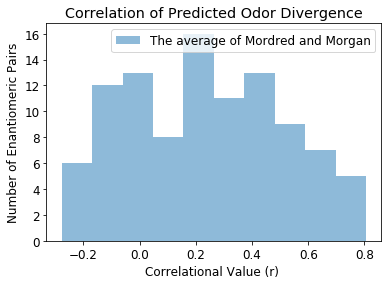

In [113]:
#This model tests on the average of the predicted values of the mordred and morgan feature dataframes
# average_model = a.model_average(mordred_data, finite_mordred, morgan_data, finite_morgan)

The mean is  0.22463095629642374 The Standard deviation is  0.024844423890784458


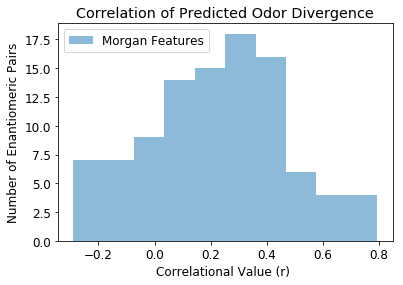

In [114]:
#This model tests on a predicted values list that contains data from a dataframe that has both morgan and mordred features
# combined = a.model(both, both_features)

c:\Users\Owner\Documents\enantiomerlist


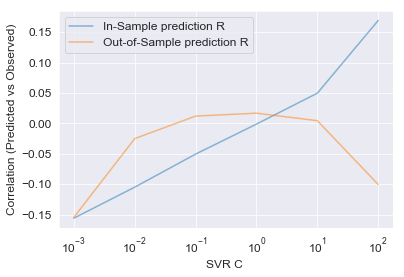

In [176]:
#Two models are represented here, one shows a test on mordred features and the other shows a test on morgan features
#mordred_rs = a.model(mordred_data, finite_mordred)
combined_features = a.model(both, both_features)
morgan_rs, predicted_values = a.model(morgan_data, finite_morgan)

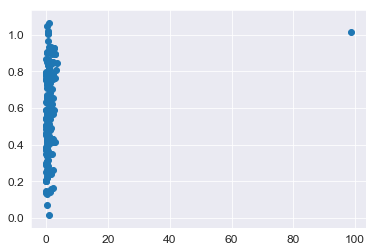

In [84]:
plt.scatter(predicted_values["log_abs"], predicted_values["predict"])
#plt.xticks([0,1,2,3], ["1x", "10x", "100x", "1000x"])

Text(0, 0.5, 'Number of Enantiomeric Pairs')

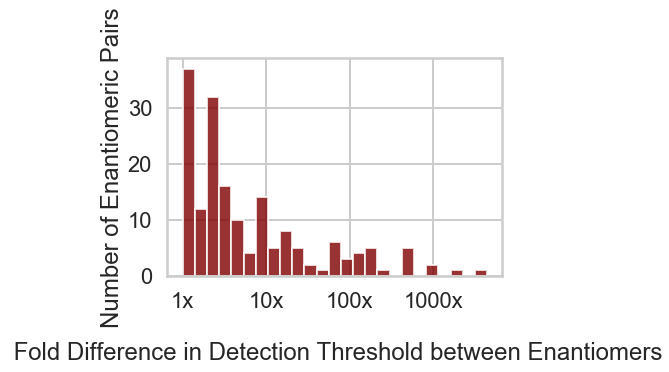

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('poster')
#plt.figure(figsize=(7,7))
stuff = half_coleman_data[half_coleman_data["log_abs"]<50]
plt.hist(stuff["log_abs"], bins=25, color="#800000", alpha=0.8)
#plt.scatter(stuff["log_abs"], stuff["log_abs"])
plt.xticks([0,1,2,3], ["1x", "10x", "100x", "1000x"])
plt.xlabel("\n Fold Difference in Detection Threshold between Enantiomers")
plt.ylabel("Number of Enantiomeric Pairs")

In [173]:
#print(x for x in half_coleman_data["log_abs"] if x < 0.4)
for x in predicted_values["log_abs"]:
    if x < 0.3:
        print(x)
        

0.0
0.0
0.21425961400680468
0.062147906748844434
0.03504274890671822
0.13033376849500614
0.0
0.0
0.027152246043614776
0.26324143477458145
0.22184874961635634
0.11270428019128832
0.0
0.12493873660829993
0.0
0.0
0.17609125905568124
0.0
0.0
0.08354605145007488
0.03826450009528262
0.0
0.0
0.04269589538414395
0.0
0.12493873660829995
0.05799194697768681
0.1504111991062202
0.06694678963061322
0.10429196663065593
0.16633142176652502
0.14061894089346233
0.07463361829690418
0.04630001965296922
0.0
0.18578407041957085
0.0
0.0
0.0
0.2708858539411167
0.09108046934733258
0.0
0.2644011003018201
0.0
0.17609125905568124
0.25078889953622063
0.033598557051758064
0.17609125905568127


In [174]:
predicted_values.reset_index()

,index,Molecule Name,Pubchem ID #,Note,Detection Threshold,Detection Units,Normalized Detection Threshold,Molecule Odour,Resources,N,...,C[C@H]1/C=C/C=C(\C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)[C@](O4)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)/C=N\N5CCN(CC5)C)/C,C[C@H]1/C=C/C=C(\C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)[C@](O4)(O/C=C/[C@@H]([C@H]([C@H]([C@@H]([C@@H]([C@@H]([C@H]1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)/C=N\N5CCN(CC5)C6CCCC6)/C,COC1=CC(=CC(=C1O)OC)/C=N\N=C/C2=CC(=C(C(=C2)OC)O)OC,C[N+]1=CC=CC=C1/C=N\O.[Cl-],COC(=O)N/N=C\C1=[N+](C2=CC=CC=C2[N+](=C1)[O-])[O-],C1=CC(=C(C(=C1)Cl)CC(=O)NC(=N)N)Cl.Cl,C1(=C(N=C(C(=N1)Cl)N)N)C(=O)NC(=N)N.O.O.Cl,CCCCCCCOC1=C(C=C(C=C1)CC=C)OC,predict,predicted
0,CC(=O)/C=C/[C@H]1C(=C)CCCC1(C)C,(R)-(-)-gamma-ionone,11389922,NaN,1.10E+01,ppb water,11.00,"Weak green, fruity, pineapple-like odor with m...",Rows 66-100 are from here: https://www.jstage....,0,...,0.097087,0.096677,0.076923,0.074074,0.096774,0.080808,0.080808,0.076923,0.655497,4.523738
1,CC1=CC[C@H](CC1=O)C(=C)C,(4R)-(-)-carvone,439570,NaN,2.00E+00,ppb,2.00,"sweet spearmint, fresh herbal",Rows 122 - 193 are from here: https://github.c...,1,...,0.094276,0.087774,0.069444,0.086957,0.107143,0.114943,0.091954,0.101695,0.622612,4.193838
2,C[C@H]1COCC2=CC3=C(C=C12)C([C@H](C3(C)C)C)(C)C,"(4R,7R)-(+)-galaxolide",14177988,NaN,4.40E-01,ppb in air,0.44,weak to almost odorless,Rows 224-267 are from here: https://github.com...,2,...,0.125373,0.117647,0.131868,0.074766,0.080000,0.080000,0.064000,0.102564,0.926919,8.451207
3,C[C@@H]1CC(=O)C=C2[C@]1(C[C@@H](CC2)C(=C)C)C,"(4R,4aS,6R)-(+) nootkatone",1268142,NaN,1.50E+01,ppm,15000.00,grapefruit odor,Rows 370-407 are from here: https://github.com...,3,...,0.118380,0.116618,0.071429,0.064516,0.088235,0.090090,0.072072,0.084507,0.846416,7.021268
4,CCC[C@@H]1CCO[C@@H](S1)C,"(2S,4R)-(+) cis-2-methyl-4-propyl-1,3-oxathiane",6931728,NaN,2.00E+00,ppb,2.00,"ctypical sulfurous, with a rubbery onion note;...",Rows 424-435 are from here: https://github.com...,4,...,0.053872,0.056426,0.027778,0.028986,0.017857,0.022989,0.000000,0.101695,0.536633,3.440592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,C[C@@H]1CC(=O)C=C2[C@]1(CC(=C(C)C)CC2)C,"(4R,4aS)-(+)-alpha-vetivone",442405,NaN,600-1000,NaN,600000.00,some grapefruit character in combination with ...,NaN,216,...,0.124611,0.116618,0.095238,0.064516,0.102941,0.108108,0.090090,0.084507,0.764151,5.809666
169,C[C@@H]1CC(=O)C[C@H]2[C@]1(C[C@@H](CC2)C(=C)C)C,"(+)-8-Dehydro-11,12-dihydronootkatone",71587038,http://www.thegoodscentscompany.com/data/rw103...,5000-10000,NaN,5000000.00,"On an odor rating scale: fresh, green, sour, d...",NaN,217,...,0.112150,0.122449,0.047619,0.043011,0.058824,0.054054,0.054054,0.056338,0.846323,7.019765
170,CC/C(=C\\CC1CC=C(C1(C)C)C)/CO,"(1\\\'R,E)-(+)-2-Methyl-4-(2\\\',2\\\',3\\\'-t...",6438196,http://www.thegoodscentscompany.com/data/rw100...,5.40E+01,ppb,54.00,fresh and strong sandalwood oil odor associate...,NaN,221,...,0.089744,0.083832,0.100629,0.119048,0.078740,0.078431,0.039216,0.135338,1.066082,11.643457
171,CC1=CC[C@H](C1(C)C)CC[C@@H](C)CO,"(-)-(2R)-2-methyl-4-[(1R)-2,2,3-trimethylcyclo...",1747970,NaN,1.87E+01,ppb,18.70,peculiar sandalwood\\\'s strongly excellent smell,NaN,223,...,0.077670,0.072508,0.089744,0.098765,0.048387,0.060606,0.020202,0.107692,0.658748,4.557724


In [178]:
columns = {"old model": [0], "new model": [0], "actual ratio": [0]}
predicted_models = pd.DataFrame(data=columns, index=predicted_values["Molecule Name"])
predicted_models.iloc[:,0] = 1
predicted_models.iloc[:,1] = predicted_values["predict"].values
predicted_models.iloc[:,2] = ["%.4g"%(10**x) for x in predicted_values["log_abs"]]
predicted_models

,old model,new model,actual ratio
Molecule Name,,,
(R)-(-)-gamma-ionone,1,0.655497,157.1
(4R)-(-)-carvone,1,0.622612,65
"(4R,7R)-(+)-galaxolide",1,0.926919,440
"(4R,4aS,6R)-(+) nootkatone",1,0.846416,4400
"(2S,4R)-(+) cis-2-methyl-4-propyl-1,3-oxathiane",1,0.536633,2
...,...,...,...
"(4R,4aS)-(+)-alpha-vetivone",1,0.764151,10
"(+)-8-Dehydro-11,12-dihydronootkatone",1,0.846323,8
"(1\\\'R,E)-(+)-2-Methyl-4-(2\\\',2\\\',3\\\'-trimethyl-cyclopent-3-enyl)-but-2-en-1-ol",1,1.066082,7.852


In [172]:
names = ["(4R)-(-)-carvone/(4S)-(+)-carvone", "(3R)-(-)-linalool/(3S)-(-)linalool"]
condensed_predicted_models = pd.DataFrame(data=columns, index=names ) 
condensed_predicted_models.iloc[0,:] = predicted_models.iloc[1,:]
condensed_predicted_models.iloc[1,:] = predicted_models.iloc[30,:]
condensed_predicted_models

,old model,new model,actual ratio
(4R)-(-)-carvone/(4S)-(+)-carvone,1,0.622612,65
(3R)-(-)-linalool/(3S)-(-)linalool,1,0.406808,9.25


[]

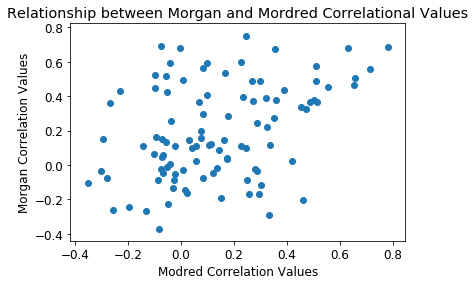

In [23]:
#This plot shows the correlation between the predicted mordred values and predicted morgan values used in the model
plt.scatter(mordred_rs, morgan_rs)
plt.title("Relationship between Morgan and Mordred Correlational Values")
plt.xlabel("Modred Correlation Values")
plt.ylabel("Morgan Correlation Values")
plt.plot()

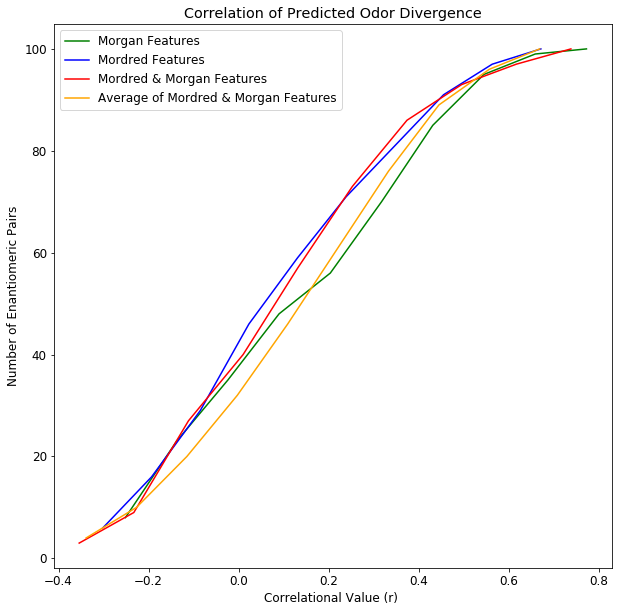

In [111]:
plt.figure(figsize=(5,5))
a.cumulativeHistogram(morgan_rs, 'green', 'Morgan Features',)
a.cumulativeHistogram(mordred_rs, 'blue', 'Mordred Features',)
a.cumulativeHistogram(combined, 'red', 'Mordred & Morgan Features')
a.cumulativeHistogram(average_model, 'orange', 'Average of Mordred & Morgan Features')

In [117]:
#This line gets rid of the mordred feature columns where the log abs values are 0 or greater than 1e100
#good_data = all_data[(all_data['log_abs']>=0) & (all_data['log_abs']<=1e100)]
#halfColeman_data['log_abs'].isnull().sum()

#NOTE: NOT SURE IF WE STILL NEED THE LINES ABOVE